In [61]:
import keras
from keras.layers import LSTM, Activation, Embedding, Dense, Dropout, Conv1D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import load_model


from pandas import DataFrame
import pandas as pd

import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_confusion_matrix(true, pred):
    true = np.argmax(true, axis=1)
    pred = np.argmax(pred, axis=1)
    cm = confusion_matrix(true, pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm)

# load the data

In [3]:
training_df = DataFrame.from_csv('train.tsv', sep='\t', header=0)
test_df = DataFrame.from_csv('test.tsv', sep='\t', header=0)

In [4]:
training_df.head()

,SentenceId,Phrase,Sentiment
PhraseId,,,
1,1,A series of escapades demonstrating the adage ...,1
2,1,A series of escapades demonstrating the adage ...,2
3,1,A series,2
4,1,A,2
5,1,series,2


In [5]:
training_texts = list(training_df['Phrase'])
testing_texts = list(test_df['Phrase'])
texts = training_texts + testing_texts

training_labels = np.array(list(training_df['Sentiment']))
training_labels_one_hot = to_categorical(training_labels)

clases = training_df['Sentiment'].unique()
number_of_classes = len(clases)

print(training_labels[0])
print(training_labels_one_hot[0])
print(clases)

1
[ 0.  1.  0.  0.  0.]
[1 2 3 4 0]


# Text preprocessing

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

training_sequnces = tokenizer.texts_to_sequences(training_texts)
testing_sequences = tokenizer.texts_to_sequences(testing_texts)

assert len(training_sequnces) == len(training_texts) 

In [7]:
max_length = 0
for seq in training_sequnces:
    max_length = max(max_length, len(seq))

### split the training set

In [8]:
training_seq_pad = pad_sequences(training_sequnces, maxlen=max_length)
test_seq_pad = pad_sequences(testing_sequences, maxlen=max_length)

x_train, x_dev, y_train, y_dev = train_test_split(training_seq_pad,
                                                    training_labels_one_hot, 
                                                    test_size=0.3, 
                                                    random_state=42)

# creating the model

In [9]:
number_of_words = len(tokenizer.word_counts)+1
embedding_size = 32

model = Sequential()
model.add(Embedding(number_of_words, embedding_size, input_length=max_length))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(number_of_classes, activation='softmax'))

model.compile(optimizer='adam', loss=categorical_crossentropy, metrics=['accuracy'])

In [10]:
#load the model if exists
# model = load_model('keras_1lstm_2dense.h5')
# model.compile(optimizer='sgd', loss=categorical_crossentropy, metrics=['accuracy'])

## training 

In [11]:
history = model.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3
109242/109242 [==============================] - 207s 2ms/step - loss: 1.1112 - acc: 0.5573
Epoch 2/3
109242/109242 [==============================] - 202s 2ms/step - loss: 0.8627 - acc: 0.6499
Epoch 3/3
109242/109242 [==============================] - 202s 2ms/step - loss: 0.7862 - acc: 0.6765


## evauation

In [12]:
model.evaluate(x_dev, y_dev)

46818/46818 [==============================] - 23s 499us/step


[0.82959852814852608, 0.66134819941048317]

In [13]:
pred_dev = model.predict(x_dev)

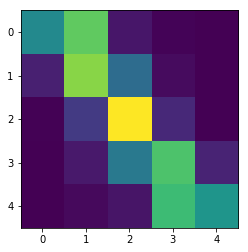

In [14]:
plot_confusion_matrix(y_dev, pred_dev)

In [15]:
model.save('keras_1lstm_2dense.h5')

# Deeper model (2 LSTM)

In [25]:
number_of_words = len(tokenizer.word_counts)+1
embedding_size = 32

model = Sequential()
model.add(Embedding(number_of_words, embedding_size, input_length=max_length))
model.add(LSTM(128, return_sequences=True ,dropout=0.3, recurrent_dropout=0.3))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(number_of_classes, activation='softmax'))

model.compile(optimizer='adam', loss=categorical_crossentropy, metrics=['accuracy'])


history = model.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3
109242/109242 [==============================] - 498s 5ms/step - loss: 1.1259 - acc: 0.5561
Epoch 2/3
109242/109242 [==============================] - 514s 5ms/step - loss: 0.8928 - acc: 0.6411
Epoch 3/3
109242/109242 [==============================] - 572s 5ms/step - loss: 0.8065 - acc: 0.6706


In [29]:
model.compile(optimizer=SGD(0.001, momentum=0.001, decay=0.001), 
              loss=categorical_crossentropy, metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=64, epochs=1)

Epoch 1/1
109242/109242 [==============================] - 555s 5ms/step - loss: 0.7338 - acc: 0.7006


In [30]:
model.evaluate(x_dev, y_dev)

46818/46818 [==============================] - 72s 2ms/step


[0.83042262315373283, 0.66329189627920881]

In [60]:
pred_vector = model.predict(test_seq_pad)

pred = np.argmax(pred_vector, axis=1)

submit_df = DataFrame(data = {'PhraseId': np.array(range(156061, 222352+1)),'Sentiment': pred})

submit_df.to_csv('Submission.csv', columns=['PhraseId', 'Sentiment'], index=False)

# With conv1D

In [63]:
number_of_words = len(tokenizer.word_counts)+1
embedding_size = 32

model = Sequential()
model.add(Embedding(number_of_words, embedding_size, input_length=max_length))
model.add(Conv1D(32, 5))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(number_of_classes, activation='softmax'))

model.compile(optimizer='adam', loss=categorical_crossentropy, metrics=['accuracy'])

In [64]:
model.fit(x_train, y_train, epochs=3)

Epoch 1/3
109242/109242 [==============================] - 238s 2ms/step - loss: 1.0497 - acc: 0.5806 1s -
Epoch 2/3
109242/109242 [==============================] - 231s 2ms/step - loss: 0.8185 - acc: 0.6679
Epoch 3/3
109242/109242 [==============================] - 226s 2ms/step - loss: 0.7386 - acc: 0.6957


In [65]:
model.compile(optimizer=SGD(0.001, momentum=0.001, 
                            decay=0.001), loss=categorical_crossentropy, metrics=['accuracy'])

In [66]:
model.fit(x_train, y_train, batch_size=64, epochs=1)

Epoch 1/1
109242/109242 [==============================] - 220s 2ms/step - loss: 0.6436 - acc: 0.7337


In [67]:
model.fit(x_train, y_train, batch_size=64, epochs=1)

Epoch 1/1
109242/109242 [==============================] - 211s 2ms/step - loss: 0.6392 - acc: 0.7364


In [68]:
model.evaluate(x_dev, y_dev)

46818/46818 [==============================] - 28s 591us/step


[0.82865189801185613, 0.66587637233542651]

In [69]:
pred_vector = model.predict(test_seq_pad)

pred = np.argmax(pred_vector, axis=1)

submit_df = DataFrame(data = {'PhraseId': np.array(range(156061, 222352+1)),'Sentiment': pred})

submit_df.to_csv('Submission.csv', columns=['PhraseId', 'Sentiment'], index=False)